## Imports and path adjustments

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import RandomSampler, BatchSampler
from sklearn.preprocessing import OneHotEncoder

from inFairness.fairalgo import SenSeI
from inFairness.distances import ProtectedEuclideanDistance, EuclideanDistance

from trainer import Trainer

In [4]:
np.random.seed(42)
torch.manual_seed(42)

## Utility functions to generate synthetic data and build dataloaders

In [5]:
def gen_synthetic_dataset(alphaMin=0.1, n=200, seed=0):
    muMin = np.array([1.5, 0])
    muMaj = np.array([-1.5, 0])
    wMin = np.array([1.5, np.sqrt(8) / 3])
    wMaj = np.array([-1.5, np.sqrt(8) / 3])

    d = 2
    sigma = 0.5

    np.random.seed(seed)
    X = np.random.normal(0, scale=sigma, size=(n, d)).astype(np.float32)
    z = np.random.choice([False, True], size=n, p=[alphaMin, 1 - alphaMin])
    X[z, :] = X[z, :] + muMaj
    X[~z, :] = X[~z, :] + muMin
    y = np.zeros(n, dtype=np.float32)
    #    noise = np.random.normal(size = n)
    noise = np.zeros(n)
    y[z] = np.sign(np.dot(X[z, :], wMaj) - np.dot(wMaj, muMaj) + noise[z])
    y[~z] = np.sign(np.dot(X[~z, :], wMin) - np.dot(wMin, muMin) + noise[~z])

    one_hot = OneHotEncoder(sparse=False, categories="auto")
    one_hot.fit(np.array(y).reshape(-1, 1))
    y_hot = one_hot.transform(np.array(y).reshape(-1, 1)).astype(np.float32)

    # will not use one hots as it is not the usual in

    return [{"X": X[i], "Y": y_hot[i], "Z": z[i]} for i in range(n)]

In [6]:
def build_train_loader(dataset, batch_size):
    sampler = RandomSampler(data_source=dataset)
    batch_sampler = BatchSampler(
        sampler, batch_size, drop_last=True
    )
    return torch.utils.data.DataLoader(
        dataset,
        batch_sampler=batch_sampler,
    )

## Create dataset, dataloader and base model

In [7]:
dataset = gen_synthetic_dataset()
dataloader = build_train_loader(dataset, batch_size=8)

In [8]:
class Model(nn.Module):

    def __init__(self):

        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

network = Model()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

## Define distance metrics and fairalgo for fairness calculations

In [9]:
distance_x = ProtectedEuclideanDistance()
distance_x.fit(protected_attributes=[0], num_attributes=2)

distance_y = EuclideanDistance()
# We don't need to fit this particular metric since it does not have any parameters.
# But we do so to maintain uniformity.
distance_y.fit()

loss = F.mse_loss

In [10]:
rho = 0.01
eps = 5.0
auditor_nsteps = 100
auditor_lr = 0.1

fairalgo = SenSeI(
    network, distance_x, distance_y, loss, rho, eps, auditor_nsteps, auditor_lr
)

## Train the model for specified iterations

In [11]:
max_iterations = 1000

trainer = Trainer(
    dataloader, fairalgo, optimizer, max_iterations
)

In [12]:
trainer.train()

## Visualize the results

<AxesSubplot:>

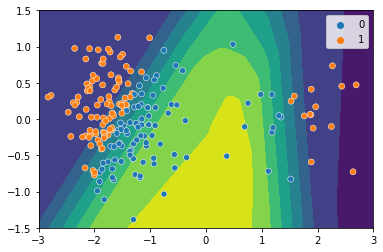

In [13]:
data_x = np.array([dataset[i]['X'] for i in range(len(dataset))])
data_y = np.array([np.argmax(dataset[i]['Y']) for i in range(len(dataset))])

network.eval()
range_x = np.linspace(-3,3,num=100).astype(np.float32)
range_y = np.linspace(-1.5,1.5, num= 100).astype(np.float32)
xx, yy = np.meshgrid(range_x, range_y, sparse=False)
y_pred = []

for i in range(100):
    x = xx[i].reshape(-1, 1)
    y = yy[i].reshape(-1, 1)
    x_test = np.hstack([x, y])
    y_pred.append(network(torch.Tensor(x_test)).detach().numpy()[:, 0])

y_pred = np.array(y_pred)
plt.contourf(range_x, range_y, y_pred)
sns.scatterplot(x=data_x[:,0], y=data_x[:,1], hue=data_y)